In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as rdm
from scipy import integrate, signal, optimize
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

Defining Coupled ODEs

In [16]:
# defining regulatory functions and their derivatives

f = lambda a: 1 / (1 + (a/a_n)**2) # regulatory function for k_n
f_prime = lambda a: -2*a/a_n**2 / (1 + (a/a_n)**2)**2 # derivative of f w.r.t. a

g = lambda a: (a/a_t)**2 / (1 + (a/a_t)**2) # regulatory function for k_t
g_prime = lambda a: 2*a/a_t**2 / (1 + (a/a_t)**2)**2 # derivative of g w.r.t. a

# f_R, the fraction of total cell synthesis capacity devoted to ribosome production
f_R = lambda a: (-f_prime(a)*g(a)*phiR_max + f(a)*g_prime(a)*phiR_min) / (-f_prime(a)*g(a) + f(a)*g_prime(a))

# f_X, fraction of cell synthesis capacity devoted to division protein production
f_X = lambda a: alpha*(phiR_max - f_R(a)) + beta

In [3]:
# defining the two regulatory function which compose dKappa_dt

def alpha_k(a,t):

    k_t = k_t0 * g(a)
    kt_prime = k_t0 * g_prime(a)
    k_n = k_n0(t) * f(a)

    return 1 + kt_prime / k_t + kt_prime * k_n / k_t**2

def beta_k(a,t):

    k_t = k_t0 * g(a)
    kt_prime = k_t0 * g_prime(a)
    k_n = k_n0(t) * f(a)

    return k_t * (f_R(a) - phiR_min) + kt_prime * k_n * (phiR_max - phiR_min) / k_t

In [4]:
# defining growth rate ODE

def dKappa_dt(kappa, t, a):

    return kappa * (beta_k(a,t) - alpha_k(a,t) * kappa)

In [5]:
def dXdt(X, t, a, kappa, V):

    dxdt = f_X(a) * kappa * V - mu * X
    return dxdt

In [6]:
# amino acid concentration ODE (variable nutrient conc.(c))

def dAAdt(a, t, kappa):

    k_n = k_n0(t) * f(a) # nutritional efficiency, depends on concentration of nutrients outside cell
    k_t = k_t0 * g(a) # translational efficiency

    dadt = k_n * (phiR_max - phiR_min) - (1 + k_n/k_t) * kappa
    return dadt

In [7]:
def dVdt(V, t, kappa):

    dvdt = kappa * V
    return dvdt

In [8]:
# packing coupled ODEs together to be solved by odeint

def odes(Species, t, del_K):

    kappa,X,a,V = Species # Tuple unpakcing of each species, equivalent to phi_R = Species[0] // a = Species[1]

    # simulating average growth dynamics of system
    kappa_ode = dKappa_dt(kappa, t, a)
    a_ode = dAAdt(a, t, kappa)

    # simulating cell-specific dynamics
    X_ode = dXdt(X, t, a, kappa, V)
    V_ode = dVdt(V, t, kappa + del_K)

    dSpeciesdt = [kappa_ode,X_ode,a_ode,V_ode]
    return dSpeciesdt

In [ ]:
# standard deviation

def std(kappa):
    a = 0.057
    b = 0.0064
    return (a * kappa/60 + b) * 60

Parameters

In [18]:
# parameters

phiR_min = 0.049 # Scott et al. 2010
phiR_max = 0.55 # Scott et al. 2010

a_n = 1e-3 # level to trigger negative feeback inhibition of amino acid supply, Scott et al. 2014
a_t = 1e-4 # amino acid level for efficient peptide elongation, Scott et al. 2014

k_t0 = 2.6
kn0_high = 62.8
kn0_low = 5.29

alpha = 2.3
beta = 0.7
mu = 0.6

Defining functions to calculate steady state initial conditions

In [10]:
# function for phi_R at steady state

def kappa_ss(a):

    k_n = k_n0(0) * f(a) # nutritional efficiency, depends on concentration of nutrients outside cell
    k_t = k_t0 * g(a) # translational efficiency

    return k_n * (phiR_max - phiR_min) / (1 + k_n / k_t)

In [11]:
# function for calculating steady state conditions for given parameters

def func(x):
    return [kappa_ss(x[0]) - x[1], # x[0]=a, x[1]=kappa
            k_t0 * g(x[0]) * (f_R(x[0]) - phiR_min) - x[1]]

#### Population level simulation

In [14]:
# packing coupled ODEs together to be solved by odeint

def odes(Species, t, del_K):

    kappa,X,a,V = Species # Tuple unpakcing of each species, equivalent to phi_R = Species[0] // a = Species[1]

    # simulating average growth dynamics of system
    kappa_ode = dKappa_dt(kappa, t, a)
    a_ode = dAAdt(a, t, kappa)

    # simulating cell-specific dynamics
    X_ode = dXdt(X, t, a, kappa + del_K, V)
    V_ode = dVdt(V, t, kappa + del_K)

    dSpeciesdt = [kappa_ode,X_ode,a_ode,V_ode]
    return dSpeciesdt

In [15]:
# simulation implementation

def SimulateAndPlot(simulation_max, iterations, replicates):

    t = np.linspace(0,simulation_max,iterations)
    cell_count = np.ones(iterations) * replicates

    # initializing each array to save intergenerataional statistics
    t_divide = np.zeros(1)
    delta_V = np.zeros(1)
    tau = np.zeros(1)
    cell_GRate = np.zeros(1)

    for x in range(replicates):
        start = True

        # initializing each array to save initial conditions for each new trajectory
        t_birth = np.zeros(1)
        V_birth = np.array([rdm.randint(120,200)/100]) # assigning random initial cell volume, in um^3
        kappa_birth = np.array([kappa0])
        a_birth = np.array([a0])

        m=0
        while m < len(t_birth):
            # start at i=1 so a[i-1]=a0 and phi_R[i-1]=phi_R0
            i = np.where(t == t_birth[m])[0][0] + 1 # starting at time index corresponding to birth a cell lineage
            new_lineage = True # denoting start of new cell lineage

            V = np.zeros(iterations)
            V[i-1] = V_birth[m]

            kappa = np.zeros(iterations)
            kappa[i-1] = kappa_birth[m]

            kappa_cell = np.zeros(iterations)
            del_K = np.random.normal(0, std(kappa[0]))
            if kappa[i-1] + del_K < 0:
                del_K = -kappa[i-1] + 1e-1
            kappa_cell[i-1] = kappa[i-1] + del_K

            a = np.zeros(iterations)
            a[i-1] = a_birth[m]

            X = np.zeros(iterations)
            if start == True:
                X[i-1] = f_X(a0)*V_birth[i-1]*0.35
                start = False

            while i < iterations:

                species_0 = [kappa[i-1], X[i-1], a[i-1], V[i-1]] # packing initial conditions

                argtuple = (del_K,)
                species = integrate.odeint(odes, species_0, t[i-1:i+1], args=argtuple) # solving for values at next timestep

                kappa[i], X[i], a[i], V[i] = species[1,:] # unpacking and storing species values for new time step
                kappa_cell[i] = kappa[i] + del_K

                X_0 = 1 # amount of division proteins required to trigger division
                # if cell has added threshold volume amount, it will then divide
                if X[i-1] >= X_0:

                    r = np.random.normal(0.5, 0.04) # drawing random value for volume allocation to daughter cell, taken from normal distribution
                    V[i] = r * V[i-1] # cell volume is divided roughly in half

                    # updating intergenerational stat arrays
                    t_divide = np.vstack((t_divide, np.array( t[i-1] )))
                    if new_lineage == True:
                        delta_V = np.vstack((delta_V, np.array( V[i-1] - V_birth[m] )))
                        tau = np.vstack((tau, np.array( t[i-1] - t_birth[m] )))
                        n = np.where(t == t_birth[m])[0][0]
                        new_lineage = False
                    else:
                        delta_V = np.vstack((delta_V, np.array( V[i-1] - V_birth[-1] )))
                        tau = np.vstack((tau, np.array( t[i-1] - t_birth[-1] )))
                        n = np.where(t == t_birth[-1])[0][0]
                    cell_GRate = np.vstack((cell_GRate, np.array( np.mean( kappa_cell[n:i-1] ) )))

                    # updating initial conditions arrays
                    t_birth = np.vstack((t_birth, np.array(t[i])))
                    V_birth = np.vstack((V_birth, np.array( (1 - r) * V[i-1] )))
                    kappa_birth = np.vstack((kappa_birth, np.array(kappa[i])))
                    a_birth = np.vstack((a_birth, np.array(a[i])))

                    X[i] = 0 # division protein concentration is reset to zero
                    del_K = np.random.normal(0, std(kappa[i]))
                    if kappa[i] + del_K < 0:
                        del_K = -kappa[i] + 1e-1

                    cell_count[i:iterations] +=1 # keeping track of total cell count over time
                i +=1
            m +=1

    # discarding initialization row
    t_divide = np.delete(t_divide, (0))
    delta_V = np.delete(delta_V, (0))
    tau = np.delete(tau, (0))
    cell_GRate = np.delete(cell_GRate, (0))

    return t_divide, delta_V, tau, cell_GRate, t, cell_count

In [ ]:
simulation_max = 7 # in hrs
iterations = 9000 # number of simulation points per replicate
replicates = 80

# concentration function
t_shift = 5 # time at which nutrient shift occurs, in hrs
t_feast = 0.75
k_n0 = lambda t: (kn0_high - kn0_low) * (np.heaviside(t-t_shift,0.5) - np.heaviside(t-(t_shift+t_feast),0.5)) + kn0_low

# solving for initial conditions to produce steady state
root = optimize.fsolve(func, [1e-2, 0.8]) # requires guess of initial conditions
kappa0 = root[1] # initial proteome fraction
a0 = 3.65e-4 #root[0] # initial amin acid concentration

t_divide, delta_V, tau, cell_GRate, t, cell_count = SimulateAndPlot(simulation_max, iterations, replicates)

Saving simulation results and/or loading in previous results

In [21]:
# saving simulation results
# np.savetxt('Simulation Results/t.csv', t, delimiter=',', header='t')
# np.savetxt('Simulation Results/cell_count.csv', cell_count, delimiter=',', header='cell_count')

# loading in previous results
df_time = pd.read_csv('Simulation Results/t.csv')
df_numCells = pd.read_csv('Simulation Results/cell_count.csv')
t_shift = 5
t_feast = 0.75

#### Calculting population growth rate

Sliding averages

In [22]:
# dynamic allocation model

n_bins = 420 # number of bins for averaging
t_min = 0 # selecting time window for analysis
t_max = 7
t_step = (t_max - t_min)/n_bins

time = np.linspace(t_min,t_max,n_bins+1)
pop_growth = np.zeros(len(time))
n_points = len(time)

# concat
df_pop = pd.concat([df_time,df_numCells], axis=1, join='inner')

# taking binned average because division events are not evenly spaced
for i in range(n_points-1):
    pop_x = df_pop.loc[(df_pop['# t'] > time[i]) & (df_pop['# t'] < time[i+1]), ['# cell_count']]
    pop_max = max(pop_x['# cell_count'])
    pop_min = min(pop_x['# cell_count'])
    pop_growth[i] = (np.log(pop_max) - np.log(pop_min)) / t_step
# removing last timepoint becuase not binned properly
time = time[0:-1]
pop_growth = pop_growth[0:-1]


# calculating moving average
window_size = 20

# Initialize an empty list to store moving averages
POPgrowth_movingAve = []
time_movingAve = []

i=0
# Loop through array to consider every window of set size
while i < len(pop_growth) - window_size + 1:

    # calculate average of current window
    growth_window_ave = np.sum(pop_growth[i:i+window_size]) / window_size
    POPgrowth_movingAve.append(growth_window_ave)

    time_window_ave = np.sum(time[i:i+window_size]) / window_size
    time_movingAve.append(time_window_ave)
    i +=1

Simulating single cell growth rate to compare

In [23]:
# ribosome mass fraction ODE (f_R variable)

def dphiR_dt(phi_R, t, a):

    k_t = k_t0 * g(a) # translational efficiency

    dpdt = k_t * (phi_R - phiR_min) * (f_R(a) - phi_R)
    return dpdt

In [24]:
# amino acid concentration ODE (variable nutrient conc.(c))

def dAAdt(a, t, phi_R, t_feast):

    k_n = k_n0(t, t_feast) * f(a) # nutritional efficiency, depends on concentration of nutrients outside cell
    k_t = k_t0 * g(a) # translational efficiency

    dadt = k_n * (phiR_max - phi_R) - k_t * (phi_R - phiR_min)
    return dadt

In [25]:
# defining growth rate function

def GrowthRate(a, phi_R):

    k_t = k_t0 * g(a)

    k = k_t * (phi_R - phiR_min)
    return k

In [26]:
# function for phi_R at steady state

def phiR_ss(a, t_feast):

    k_n = k_n0(t_min,t_feast) * f(a) # nutritional efficiency, depends on concentration of nutrients outside cell
    k_t = k_t0 * g(a) # translational efficiency

    return (k_n*phiR_max + k_t*phiR_min) / (k_n + k_t)

In [27]:
# function for calculating steady state conditions for given parameters

def func(x, t_feast):
    return [phiR_ss(x[0], t_feast) - x[1], # x[0]=a, x[1]=phi_R
            f_R(x[0]) - x[1]]

Defining Model

In [28]:
# packing coupled ODEs together to be solved by odeint

def odes(Species, t, t_feast):

    phi_R,a = Species # Tuple unpacking of each species, equivalent to phi_R = Species[0] // a = Species[1]

    phiR_ode = dphiR_dt(phi_R, t, a)
    a_ode = dAAdt(a, t, phi_R, t_feast)

    dSpeciesdt = [phiR_ode,a_ode]
    return dSpeciesdt

In [29]:
def model(t, t_feast):

    # calculating initial conditions
    argtuple = (t_feast,)
    root = optimize.fsolve(func, [1e-4, 0.4], args=argtuple) # requires an initial guess
    species_0 = [root[1],root[0]] # [phi_R0,a0]

    species = integrate.odeint(odes, species_0, t, args=argtuple) #numerically solving coupled ODEs

    phi_R = species[:,0]
    a = species[:,1]

    kappa = GrowthRate(a, phi_R)

    return kappa

Figure 6

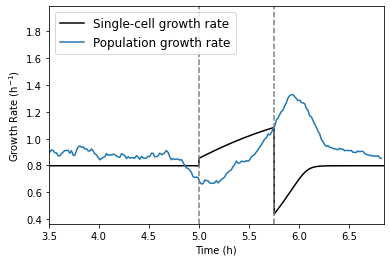

In [30]:
t_min = 0
t_max = 5
t_shift = 3
t_feast = 0.75

fig = plt.figure()
t = np.linspace(t_min,t_max,10000)
k_n0 = lambda t, t_feast: (kn0_high - kn0_low) * (np.heaviside(t-t_shift,0.5) - np.heaviside(t-(t_shift+t_feast),0.5)) + kn0_low
plt.plot(t+2, model(t, t_feast), label='Single-cell growth rate', color='k')
# used t+2 because of simulation glitch when using real t

plt.plot(time_movingAve, POPgrowth_movingAve/np.log(2), label='Population growth rate')
plt.axvline(t_shift+2, linestyle='--', color='gray')
plt.axvline(t_shift+t_feast+2, linestyle='--', color='gray')

plt.xlabel('Time (h)')
plt.ylabel('Growth Rate (h$^{-1}$)')
plt.rc('font', size=12) #controls default text size
plt.xlim(3.5,6.85)
plt.legend()
plt.show()